<a href="https://colab.research.google.com/github/paper-prism/paper-prism/blob/main/gemma_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisites

In [1]:
# 이 패키지는 메모리와 성능 최적화를 위한 수치 연산 라이브러리로, 특히 FP16/INT8 처리를 지원하여 대규모 모델의 메모리 사용량을 줄이는 데 유용함
!pip3 install -q -U bitsandbytes

# PEFT는 Parameter-Efficient Fine-Tuning의 약자로, 대형 언어 모델을 미세 조정할 때 적은 수의 파라미터만을 조정하는 방법을 제공하여 훈련 시간을 줄여주는 패키지
!pip3 install -q -U peft

# trl은 Transformer Reinforcement Learning의 약자로, 강화 학습을 Transformer 기반 모델과 결합하여 훈련하는 데 사용되는 패키지
!pip3 install -q -U trl

# 이 패키지는 분산 및 가속화된 학습을 간편하게 할 수 있도록 도와주는 도구로, 특히 여러 GPU나 TPU에서 훈련할 때 유용함
!pip3 install -q -U accelerate

# datasets는 다양한 자연어 처리 데이터셋을 쉽게 로드하고 처리할 수 있게 해주는 Hugging Face의 데이터셋 라이브러리
!pip3 install -q -U datasets

# Hugging Face의 transformers는 BERT, GPT 등 다양한 사전 훈련된 언어 모델을 불러와 사용할 수 있게 해주는 라이브러리로, NLP 작업을 손쉽게 수행 가능
!pip3 install -q -U transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatibl

In [2]:
!nvidia-smi

Sat Sep 21 11:27:42 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# pandas 라이브러리를 pd라는 별칭으로 불러옴
# pandas는 데이터 분석을 위한 Python 라이브러리로, 데이터프레임을 쉽게 다룰 수 있도록 도와줌
import pandas as pd

# Hugging Face의 datasets 모듈에서 Dataset 클래스와 load_dataset 함수를 불러옴
# Dataset 클래스는 데이터셋을 관리하는 객체이며, load_dataset 함수는 Hugging Face 허브에서 다양한 데이터셋을 로드하는 데 사용됨
from datasets import Dataset, load_dataset

# Hugging Face 허브에 로그인하기 위한 함수
# notebook_login은 Hugging Face의 모델 및 데이터셋을 사용할 때, 사용자 인증을 돕는 함수
from huggingface_hub import notebook_login

# peft(Prompt-Efficient Fine-Tuning) 모듈에서 LoraConfig와 PeftModel을 불러옴
# LoraConfig는 LoRA (Low-Rank Adaptation)의 설정을 정의하는 클래스이고, PeftModel은 파라미터 효율적 미세 조정이 적용된 모델을 나타냄
from peft import LoraConfig, PeftModel

# transformers 모듈에서 필요한 객체들을 불러옴
# AutoModelForCausalLM은 사전 학습된 causal language model을 자동으로 로드하는 클래스
# AutoTokenizer는 사전 학습된 토크나이저를 자동으로 로드하는 클래스
# BitsAndBytesConfig는 8비트 연산 최적화를 위한 설정을 담은 클래스
# TrainingArguments는 훈련 시 사용할 설정들을 담는 클래스
# pipeline은 Hugging Face의 사전 학습된 모델을 손쉽게 불러와 다양한 작업에 사용할 수 있게 해주는 유틸리티 함수
# logging은 transformers의 로깅 도구로, 로그 출력을 관리할 수 있음
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging,
)

# trl(Transformer Reinforcement Learning) 모듈에서 SFTTrainer를 불러옴
# SFTTrainer는 Supervised Fine-Tuning을 위한 트레이너 클래스로, 사전 학습된 언어 모델을 미세 조정할 때 사용
from trl import SFTTrainer

import torch


# Model Loading

In [4]:
notebook_login()

In [5]:
# 주석으로 처리된 여러 model_id 중에서 'google/gemma-2b-it' 모델을 선택
# 이 모델은 Gemma의 2B 파라미터 모델로, 'it'는 instruction tuning이 된 버전을 의미
# instruction 모델은 일반 base 모델과 달리 특정 작업을 위한 지시(명령어) 템플릿을 포함하고 있음
model_id = "google/gemma-2-2b"
# model_id = "google/gemma-2-2b-it"


# BitsAndBytesConfig 설정을 사용하여 모델을 4비트로 양자화함
# load_in_4bit=True: 모델을 4비트로 로드해 메모리 사용량을 줄임
# bnb_4bit_use_double_quant=True: 이중 양자화를 사용해 모델의 메모리 효율을 더 높임
# bnb_4bit_quant_type="nf4": 양자화 유형을 NF4로 설정 (효율적인 수치 표현 방식 중 하나)
# bnb_4bit_compute_dtype=torch.bfloat16: 계산 시 bfloat16 데이터 타입을 사용해 계산 정확도를 유지하면서 속도를 높임
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# 선택한 모델을 AutoModelForCausalLM을 통해 로드함
# from_pretrained() 메소드를 사용해 사전 학습된 모델을 로드하고, 양자화 설정(bnb_config)을 적용함
# device_map={"":0}: 모델이 GPU의 첫 번째 장치(장치 번호 0)에서 실행되도록 지정
model = AutoModelForCausalLM.from_pretrained(
    model_id, quantization_config=bnb_config,
    device_map={"":0}
)

# 선택한 모델에 맞는 토크나이저를 로드함
# from_pretrained() 메소드를 통해 모델과 동일한 사전 학습된 토크나이저를 불러옴
# add_eos_toekn=True: 문장 끝에 EOS(end of sentence) 토큰을 자동으로 추가하는 설정
tokenizer = AutoTokenizer.from_pretrained(model_id, add_eos_toekn=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/818 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/481M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

# Load & Format The Dataset

Spend 80% of my time curating the data and coming up with the right format with the dataset and 20% of the time in fineting

Preparing Data for fine tuning

In [7]:
import os
import shutil
import stat
from kaggle.api.kaggle_api_extended import KaggleApi

# 1. /root/.config/kaggle 디렉토리를 생성
config_dir = os.path.expanduser("~/.config/kaggle")
os.makedirs(config_dir, exist_ok=True)

# 2. 현재 작업 디렉토리에 있는 kaggle.json 파일을 /root/.config/kaggle 디렉토리로 복사
source_file = "kaggle.json"  # kaggle.json 파일의 경로
destination_file = os.path.join(config_dir, "kaggle.json")

if os.path.exists(source_file):
    shutil.copy(source_file, destination_file)
    os.chmod(destination_file, stat.S_IRUSR | stat.S_IWUSR)  # 권한 설정
else:
    raise FileNotFoundError(f"{source_file} 파일이 현재 디렉토리에 없습니다.")

# 3. Kaggle API를 사용하여 데이터셋 다운로드
api = KaggleApi()
api.authenticate()

# 다운로드할 데이터셋 ID
dataset_id = "nelgiriyewithana/emotions"

# 데이터셋 다운로드
api.dataset_download_files(dataset_id, path=".", unzip=True)

print(f"Dataset '{dataset_id}' downloaded successfully!")


Dataset URL: https://www.kaggle.com/datasets/nelgiriyewithana/emotions
Dataset 'nelgiriyewithana/emotions' downloaded successfully!


In [8]:
data = pd.read_csv('/content/text.csv', index_col = 0)

data.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


In [14]:
# drop_duplicates() 메서드를 사용하여 데이터프레임 'text'에서 중복된 행을 제거합니다.
# ignore_index=True 옵션은 중복 제거 후 인덱스를 재설정합니다.
# inplace=True 옵션은 원본 데이터프레임을 직접 수정하여 중복 행을 제거합니다.
data.drop_duplicates(ignore_index=True, inplace=True)

print(f'shape: {data.shape}')
print('\n')
print(f'isnull: \n{data.isnull().sum()}')
print('\n')
print(f'duplicated: {data.duplicated().sum()}')
print(data.columns)
print(f"unique labels count {data['label'].unique()}")

shape: (416123, 2)


isnull: 
text     0
label    0
dtype: int64


duplicated: 0
Index(['text', 'label'], dtype='object')
unique labels count [4 0 2 1 5 3]


In [15]:
data.tail()

,text,label
416118,i feel like telling these horny devils to find...,2
416119,i began to realize that when i was feeling agi...,3
416120,i feel very curious be why previous early dawn...,5
416121,i feel that becuase of the tyranical nature of...,3
416122,i think that after i had spent some time inves...,5


In [16]:
# 감정(label) 매핑을 정의한 딕셔너리입니다.
# 각 키는 'label' 값이고, 각 값은 해당 감정에 해당하는 문자열입니다.
emotions = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

# 'label' 열의 값을 emotions 딕셔너리의 값으로 대체하여 새로운 'emotion' 열을 만듭니다.
# data['label'] 열의 각 값이 emotions 딕셔너리의 키와 일치하면 해당 키의 값(감정)이 'emotion' 열에 대입됩니다.
data['emotion'] = data['label'].replace(emotions)

# 데이터프레임의 상위 5개의 행을 출력하여 변경 사항을 확인합니다.
# 'emotion' 열에 매핑된 감정 문자열이 잘 적용되었는지 확인할 수 있습니다.
data.head()

,text,label,emotion
0,i just feel really helpless and heavy hearted,4,fear
1,ive enjoyed being able to slouch about relax a...,0,sadness
2,i gave up my internship with the dmrg and am f...,4,fear
3,i dont know i feel so lost,0,sadness
4,i am a kindergarten teacher and i am thoroughl...,4,fear


<ipython-input-17-6c032e928e56>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=count.index, y=count.values, ax=axs, palette="viridis")


Text(0.5, 1.0, 'Count of Categories')

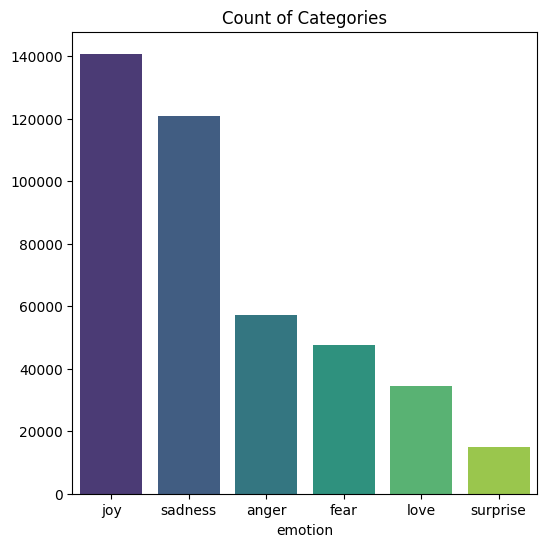

In [17]:
import seaborn as sns
from matplotlib import pyplot as plt

# emotion category 시각화
count = data['emotion'].value_counts()

fig, axs = plt.subplots(figsize = (6, 6), facecolor='white')
palette = sns.color_palette("viridis")
sns.set_palette(palette)

sns.barplot(x=count.index, y=count.values, ax=axs, palette="viridis")
axs.set_title('Count of Categories')

In [18]:
dataset = Dataset.from_pandas(data)

# 데이터셋을 훈련 및 테스트 데이터셋으로 분할
# test_size=0.2: 전체 데이터의 20%를 테스트 데이터로 할당하고, 나머지 80%를 훈련 데이터로 할당
dataset = dataset.train_test_split(test_size=0.2)

# 훈련 데이터와 테스트 데이터를 각각 추출
train_data = dataset["train"]  # 80% 훈련 데이터
test_data = dataset["test"]    # 20% 테스트 데이터


In [19]:
train_data

Dataset({
    features: ['text', 'label', 'emotion'],
    num_rows: 332898
})

In [20]:
test_data

Dataset({
    features: ['text', 'label', 'emotion'],
    num_rows: 83225
})

In [21]:
# label 칼럼 제거
train_data = train_data.remove_columns(['label'])
test_data = test_data.remove_columns(['label'])

# 칼럼명 변경
train_data = train_data.rename_column("text", "prompt")
train_data = train_data.rename_column("emotion", "response")

test_data = test_data.rename_column("text", "prompt")
test_data = test_data.rename_column("emotion", "response")

# 칼럼명 변경된 데이터셋 확인
print(train_data.column_names)  # ['prompt', 'response']
print(test_data.column_names)  # ['prompt', 'response']

['prompt', 'response']
['prompt', 'response']


# LoRA Config

In [22]:
from peft import LoraConfig, PeftModel, prepare_model_for_kbit_training, get_peft_model

# 모델에 대해 gradient checkpointing을 활성화
# gradient checkpointing은 메모리 사용량을 줄이기 위한 기법으로, 역전파(backpropagation) 시 필요한 메모리 소비를 줄여줌
# 이를 통해 대규모 모델을 훈련할 때 GPU 메모리를 절약할 수 있음
model.gradient_checkpointing_enable()

# 모델을 양자화된 k-bit(예: 4bit, 8bit) 훈련에 맞게 준비
# prepare_model_for_kbit_training 함수는 모델을 k-bit 훈련에 적합하도록 변환하며, 메모리 사용량을 크게 줄임
model = prepare_model_for_kbit_training(model)


In [23]:
print(model)

Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2SdpaAttention(
          (q_proj): Linear4bit(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=2048, out_features=2304, bias=False)
          (rotary_emb): Gemma2RotaryEmbedding()
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear4bit(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear4bit(in_features=9216, out_features=2304, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (post_attention_layerno

In [24]:
# bitsandbytes에서 사용할 linear layers를 결정하는 함수
# 4비트 양자화가 적용된 Linear 레이어(bnb.nn.Linear4bit)를 찾아냄

import bitsandbytes as bnb

def find_all_linear_names(model):
    """
    모델에서 4비트 또는 8비트 양자화된 Linear 레이어 이름을 찾는 함수.

    :param model: nn.Module: 모델
    :return: list: 양자화된 Linear 레이어 이름들의 리스트
    """

    # 4비트 양자화된 Linear 레이어 클래스 설정
    # cls = bnb.nn.Linear4bit: 4비트 양자화된 Linear 레이어 사용
    cls = bnb.nn.Linear4bit

    # LoRA(Low-Rank Adaptation)로 변경할 모듈 이름을 저장할 집합
    lora_module_names = set()

    # 모델 내 모든 모듈을 탐색
    for name, module in model.named_modules():
        # 모듈이 4비트 양자화된 Linear 레이어(cls)인지 확인
        if isinstance(module, cls):
            # 모듈 이름을 분할하여 LoRA 적용할 모듈 이름을 찾음
            # 모듈 이름이 '.'로 구분되어 있을 경우 마지막 이름을 사용
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])

        # 'lm_head'는 LoRA 적용에서 제외 (16-bit 환경에서 필요)
        if 'lm_head' in lora_module_names:
            lora_module_names.remove('lm_head')

    # LoRA 적용할 모듈 이름들의 리스트 반환
    return list(lora_module_names)


In [25]:
# find_all_linear_names 함수를 사용하여 모델에서 LoRA 적용할 4비트 양자화된 Linear 레이어 이름을 찾음
modules = find_all_linear_names(model)  # 변경될 파라미터가 포함된 모듈들
# 찾은 모듈 이름들을 출력
print(modules)


['down_proj', 'q_proj', 'up_proj', 'o_proj', 'v_proj', 'k_proj', 'gate_proj']


In [26]:
from peft import LoraConfig, get_peft_model

# LoRA 설정 구성
lora_config = LoraConfig(
    r=64,  # LoRA 랭크: 행렬의 차원을 줄여 파라미터 효율성을 높임
    lora_alpha=32,  # LoRA 스케일링 파라미터로, 학습률을 조정
    target_modules=modules,  # LoRA를 적용할 타겟 모듈 (4비트 양자화된 Linear 레이어)
    lora_dropout=0.05,  # 드롭아웃 확률로, 과적합을 방지하기 위해 일부 노드를 무작위로 비활성화
    bias="none",  # 편향(bias)은 학습하지 않음
    task_type="CAUSAL_LM"  # 작업 유형을 'CAUSAL_LM'으로 지정 (Causal Language Modeling, 예: GPT 모델과 같은 작업)
)

# LoRA를 적용한 모델 생성
model = get_peft_model(model, lora_config)


In [27]:
# 모델에서 훈련 가능한 파라미터와 전체 파라미터 개수를 가져옴
trainable, total = model.get_nb_trainable_parameters()

# 훈련 가능한 파라미터의 수와 전체 파라미터의 수를 출력
# 또한, 전체 파라미터 중 훈련 가능한 파라미터가 차지하는 비율(%)을 계산해 출력
print(f"Trainable: {trainable} | Total: {total} | Percentage: {trainable/total*100:.4f}%")


Trainable: 83066880 | Total: 2697408768 | Percentage: 3.0795%


# Fine-Tuning

In [28]:
import transformers
from trl import SFTTrainer
import torch

# 토크나이저의 패딩 토큰을 EOS 토큰으로 설정 (필요 시 패딩에 EOS 토큰 사용)
tokenizer.pad_token = tokenizer.eos_token

# CUDA 캐시 비우기 (메모리 최적화)
torch.cuda.empty_cache()

# SFTTrainer 인스턴스를 생성하여 훈련을 설정
trainer = SFTTrainer(
    model=model,  # 미세 조정할 모델
    train_dataset=train_data,  # 훈련 데이터셋
    eval_dataset=test_data,  # 평가 데이터셋
    dataset_text_field="prompt",  # 데이터셋에서 텍스트 필드를 나타내는 컬럼 이름
    peft_config=lora_config,  # LoRA 설정 (저차 적응 기법 사용)

    # TrainingArguments 설정
    args=transformers.TrainingArguments(
        per_device_train_batch_size=1,  # 각 디바이스(GPU)당 배치 크기
        gradient_accumulation_steps=4,  # 4개의 배치를 누적하여 그래디언트 업데이트
        warmup_steps=3,  # 학습 초기 단계에서 워밍업 스텝 설정 (정수로 설정)
        max_steps=100,  # 최대 100 스텝 동안 훈련
        learning_rate=2e-4,  # 학습률 설정
        logging_steps=1,  # 매 스텝마다 로그를 기록
        output_dir="outputs",  # 훈련 결과 저장 경로
        optim="paged_adamw_8bit",  # 8비트 AdamW 최적화 기법 사용 (메모리 효율적)
        save_strategy="epoch",  # 매 epoch마다 모델 저장
    ),

    # 데이터 수집기 설정: MLM(False)를 통해 언어 모델링을 위한 데이터 전처리
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:292: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:321: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(


Map:   0%|          | 0/332898 [00:00<?, ? examples/s]

Map:   0%|          | 0/83225 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:396: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
max_steps is given, it will override any value given in num_train_epochs


In [29]:
# 모델에서 'use_cache' 옵션을 비활성화하여 경고 메시지를 없앰
# 'use_cache'가 True로 설정되면 훈련 중 메모리 사용량이 증가할 수 있으므로, 훈련 단계에서는 이를 비활성화
# 추론 시에는 성능을 위해 'use_cache'를 다시 활성화하는 것이 좋음
model.config.use_cache = False  # 경고 메시지 제거 (훈련 중에는 캐시를 사용하지 않음)

# SFTTrainer를 사용해 모델 훈련 시작
trainer.train()


It is strongly recommended to train Gemma2 models with the `eager` attention implementation instead of `sdpa`. Use `eager` with `AutoModelForCausalLM.from_pretrained('<path-to-checkpoint>', attn_implementation='eager')`.
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:295: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with torch.enable_grad(), device_autocast_ctx, torch.cpu.amp.autocast(**ctx.cpu_autocast_kwargs):  # type: ignor

Step,Training Loss
1,4.451000
2,4.756500
3,6.572500
4,4.324500
5,3.898000
6,4.298800
7,3.699800
8,5.275800
9,3.710000
10,3.719600


TrainOutput(global_step=100, training_loss=3.580426082611084, metrics={'train_runtime': 239.2289, 'train_samples_per_second': 1.672, 'train_steps_per_second': 0.418, 'total_flos': 101796344294400.0, 'train_loss': 3.580426082611084, 'epoch': 0.0012015692494397683})

In [32]:
new_model = "gemma-Code-Instruct-Finetune-test-v2" #Name of the model you will be pushing to huggingface model hub

In [33]:
# 트레이너가 사용하는 모델을 지정한 경로(new_model)에 저장
trainer.model.save_pretrained(new_model)

In [36]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
from torch import nn

# 감정 레이블 수
num_labels = 6

# 새로운 미세 조정된 모델 로드 (new_model 경로에 있는 모델 사용)
# new_model은 미세 조정된 모델이 저장된 디렉토리 경로
new_model_path = new_model  # 미세 조정된 모델이 저장된 디렉토리 경로

# AutoModelForCausalLM 로드 및 hidden_states 출력 활성화
base_model = AutoModelForCausalLM.from_pretrained(
    new_model_path,
    low_cpu_mem_usage=True,
    return_dict=True,
    output_hidden_states=True,  # hidden_states 출력을 활성화
    torch_dtype=torch.float16,
    device_map={"": 0},
)

# 감정 분류기 헤드 정의
class EmotionClassifier(nn.Module):
    def __init__(self, model, num_labels):
        super(EmotionClassifier, self).__init__()
        self.model = model  # 미세 조정된 모델을 베이스 모델로 사용
        # 분류기를 위한 Linear Layer
        self.classifier = nn.Linear(model.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask=None, labels=None):
        # 모델 출력 (기존 모델의 히든 상태)
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.hidden_states[-1]  # 마지막 히든 상태 추출

        # 감정 예측: 마지막 토큰에 대한 히든 상태를 분류기로 전달하여 로짓 계산
        logits = self.classifier(hidden_states[:, -1, :])
        return logits



Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [39]:
# 감정 분류기가 추가된 모델 생성
emotion_model = EmotionClassifier(base_model, num_labels=num_labels).to("cuda:0")
emotion_model = emotion_model.half().to("cuda:0")

# 토크나이저 로드 (미세 조정된 모델과 일치하는 토크나이저 사용)
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"


In [40]:
# 감정 예측 함수
def predict_emotion(text, model, tokenizer, max_length=128):
    """
    입력 텍스트에 대해 감정을 예측하는 함수.

    :param text: str: 입력 텍스트
    :param model: AutoModelForCausalLM: 감정 분류 모델
    :param tokenizer: AutoTokenizer: 토크나이저
    :param max_length: int: 텍스트 토큰의 최대 길이 (default: 128)
    :return: str: 예측된 감정
    """
    # 텍스트를 토큰화하여 모델 입력으로 변환
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to("cuda:0")

    # 모델 예측
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs  # 로짓 값 추출

    # 감정 레이블 예측 (가장 높은 로짓 값 선택)
    predicted_label = torch.argmax(logits, dim=-1).item()

    # 예측된 레이블 확인
    print(f"Predicted Label: {predicted_label}")

    # 감정 매핑
    emotions = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}
    # 예측된 레이블을 감정 문자열로 변환
    predicted_emotion = emotions.get(predicted_label, "unknown")

    return predicted_emotion


In [41]:
# 예시 텍스트로 감정 예측 수행
input_text = "This is a masterpiece, wow!"
predicted_emotion = predict_emotion(input_text, emotion_model, tokenizer)
print("Predicted Emotion: ", predicted_emotion)

Predicted Label: 3
Predicted Emotion:  anger
